In [1]:
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)
import skewer_computations as skc
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
from scipy.interpolate import interp1d


ModuleNotFoundError: No module named 'forestflow'

Load the data

In [ ]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
# set phase
phase = "sim_minus"
# set axis number
axis = 1

In [ ]:
# load the skewers x 
meas_path = "/Users/mlokken/research/lyman_alpha/data/"
delta_x = np.load(meas_path+"snap_{:d}/delta_x/skewers_6_psim_minus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num))
delta_flux_x = delta_x['delta_flux_x'] # these are already normalized
Np = delta_flux_x.shape[1]
L = delta_x['L_Mpc']
pix_spacing = L/Np
print("pixel spacing is", pix_spacing, "Mpc")
# xpar = delta_x['xpar'] # this is still wrong for some reason, redefined below
delta_x.close()
xpar = np.arange(0, L, pix_spacing)+pix_spacing/2.



In [ ]:
Np = delta_flux_x.shape[1]
nskew = delta_flux_x.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")

# bin delta_flux along line-of-sight
binsize = 10
if Np%binsize != 0:
    print("Np is not divisible by binsize")
    sys.exit()
delta_flux_b, xpar_b = est.bin_spectra(delta_flux_x, xpar, binsize)
Np_b=delta_flux_b.shape[1]
pix_spacing_b = xpar_b[1]-xpar_b[0]
print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing_b} Mpc")
delta_flux_k = np.fft.rfft(delta_flux_b)*np.sqrt(pix_spacing_b/Np_b)
Nk = delta_flux_k.shape[1]
# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])
subsel=False
nsub=5000
if subsel:
    randoms = rng.choice(len(positions), size=nsub)
    sel = np.zeros(len(positions), dtype=bool)
    sel[randoms] = True
else:
    sel = np.ones(len(positions), dtype=bool)
positions_sel = np.copy(positions)
positions_sel[~sel] = np.nan
delta_flux_x[~sel] = np.nan
delta_flux_b[~sel] = np.nan
delta_flux_k[~sel] = np.nan

# make masked arrays
delta_flux_x = np.ma.masked_invalid(delta_flux_x)
delta_flux_b = np.ma.masked_invalid(delta_flux_b)
delta_flux_k = np.ma.masked_invalid(delta_flux_k)
positions_sel = np.ma.masked_invalid(positions_sel)

# reshape into a grid
delta_flux_x_grid = np.reshape(delta_flux_x, (int(nside), int(nside), Np))
delta_flux_b_grid = np.reshape(delta_flux_b, (int(nside), int(nside), Np_b))
delta_flux_k_grid = np.reshape(delta_flux_k, (int(nside), int(nside), Nk))
position_grid = np.reshape(positions_sel, (int(nside), int(nside), 2))

delta_x_matrix_binned = est.make_delta_x_matrix(L, Np_b, xpar_b)

In [35]:
# in the subselected forest, do some masking schemes along the line-of-sight axis
# 1: random masking of 1-5 pixels in each skewer

delta_flux_randmasked_b = np.copy(delta_flux_b)
masklocs_per_skewer = []
for i in range(nskew):
    nmask = rng.integers(1, 6)
    masklocs = rng.choice(np.arange(Np_b), size=nmask, replace=False)
    masklocs_per_skewer.append(masklocs)
    delta_flux_randmasked_b[i, masklocs] = 0
# reshape into a grid
delta_flux_randmasked_b_grid = np.reshape(delta_flux_randmasked_b, (int(nside), int(nside), Np_b))

# 2: 'skyline-like' masking: mask a range of N pixels 1/x of the way through the box
skyline_width = 2
boxdiv = 4
maskrange = np.arange(Np_b//boxdiv, Np_b//boxdiv+skyline_width)
delta_flux_skyline_b = np.copy(delta_flux_b_grid)
delta_flux_skyline_b[:, :, maskrange] = 0

# 3: put a DLA-like mask (20 pixels at once) at random positions
ndla = nside//10 # 10% of skewers in the box will have dlas
dla_width = 20
dla_locs_x = rng.choice(np.arange(nside), size=ndla, replace=False)
dla_locs_y = rng.choice(np.arange(nside), size=ndla, replace=False)
dla_locs_zstart = rng.choice(np.arange(Np_b-dla_width), size=ndla, replace=False)

delta_flux_dla_b = np.copy(delta_flux_b_grid)
for x, y, zstart in zip(dla_locs_x, dla_locs_y, dla_locs_zstart):
    delta_flux_dla_b[x, y, zstart:zstart + dla_width] = 0


In [74]:
# now recompute the delta_ks for the masked skewers
delta_flux_randmasked_k = np.fft.rfft(delta_flux_randmasked_b_grid, axis=2)*np.sqrt(pix_spacing_b/Np_b)
delta_flux_skyline_k = np.fft.rfft(delta_flux_skyline_b, axis=2)*np.sqrt(pix_spacing_b/Np_b)
delta_flux_dla_k = np.fft.rfft(delta_flux_dla_b, axis=2)*np.sqrt(pix_spacing_b/Np_b)


Text(0.5, 0.92, 'Random masking of 1-5 pixels in each skewer')

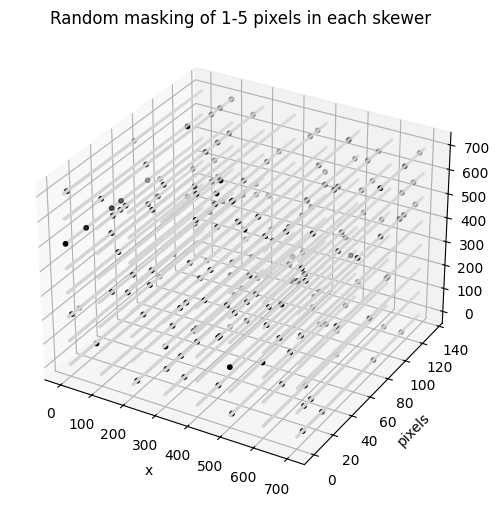

In [71]:
# visualize the masks
cm = plt.cm.jet
# 1: plot a 3D cube showing the masked pixel locations
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(0, nside, 100):
    for j in range(0, nside, 100): # only plot every 10th column
        # get a random color for this line of pixels
        color = cm((counter*10)%100)
        if counter<300:
            masklocs = masklocs_per_skewer[i*nside+j]
            # plot a line of light grey pixels
            ax.scatter(i*np.ones(Np_b), np.arange(Np_b), j*np.ones(Np_b), c='lightgrey', s=2)
            # fill in the masked pixels for this line with black
            ax.scatter(i*np.ones(len(masklocs)), masklocs, j*np.ones(len(masklocs)), c='k', s=10)
            counter +=1
        else:
            break
ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("Random masking of 1-5 pixels in each skewer")

Text(0.5, 0.92, 'Skyline-like masking')

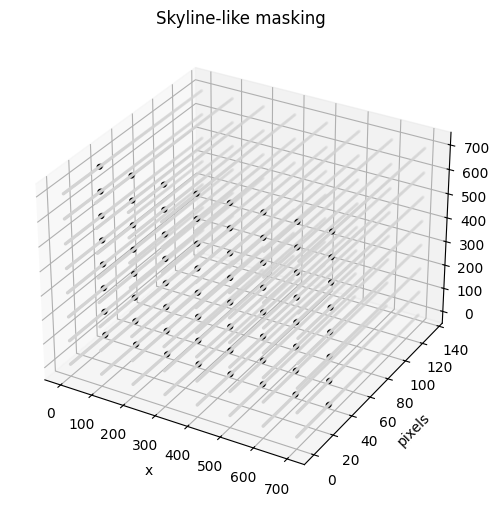

In [70]:
# 2: skyline visualization

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(0, nside, 100):
    for j in range(0, nside, 100): # only plot every 10th column
        # get a random color for this line of pixels
        color = cm((counter*10)%100)
        if counter<300:
            masklocs = masklocs_per_skewer[i*nside+j]
            # plot a line of light grey pixels
            ax.scatter(i*np.ones(Np_b), np.arange(Np_b), j*np.ones(Np_b), c='lightgrey', s=2, zorder=counter)
            # fill in the masked pixels for this line with black
            ax.scatter(i*np.ones(skyline_width), maskrange, j*np.ones(skyline_width), c='k', s=10, zorder=counter+1)
            counter +=1
        else:
            break
ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("Skyline-like masking")

Text(0.5, 0.92, 'DLA-like masking')

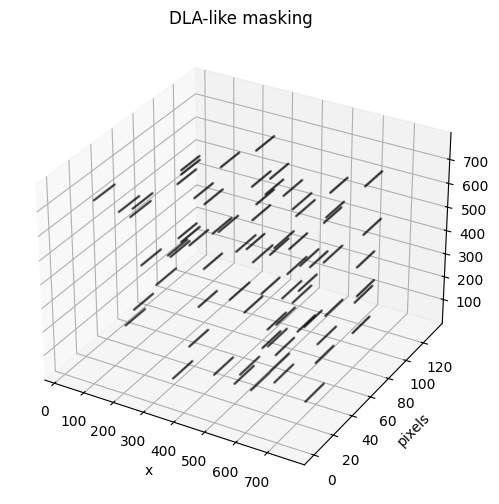

In [68]:
# 3: the DLA_like mask

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')

for c, dlax in enumerate(dla_locs_x):
    dlay = dla_locs_y[c]
    ax.scatter(dlax*np.ones(dla_width), dla_locs_zstart[c]+np.arange(dla_width), dlay*np.ones(dla_width), c='k', alpha=.4, s=1)

ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("DLA-like masking")

Load the model

In [72]:
# get the model

path_program = "/Users/mlokken/research/lyman_alpha/software/ForestFlow/"

folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)

In [82]:
# read the model
central = Archive3D.get_testing_data("mpg_central")
zs = np.array([central[snap_num]['z']]) 

k3d_Mpc = central[snap_num]['k3d_Mpc']
mu3d = central[snap_num]['mu3d']
p3d_Mpc = central[snap_num]['p3d_Mpc']
Plin = central[snap_num]['Plin']

k1d_Mpc = central[snap_num]['k_Mpc']
p1d_Mpc = central[snap_num]['p1d_Mpc']

arinyo_params = central[snap_num]['Arinyo'] # best-fitting Arinyo params
cosmo_params  = central[snap_num]['cosmo_params']

print(zs)

[3.]


In [83]:
# input the details into the ArinyoModel class
cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=1000)
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=1000)
p1d = arinyo.P1D_Mpc(zs[0], np.linspace(0,10,20), parameters=arinyo_params) # get P1D at target z

In [84]:
# Get the weighting matrix
Leff=1000
Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
spacing_fine=Leff/Np_fine
kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)
xi_fid = np.fft.irfft(p1d_fine) / spacing_fine # to cancel the Mpc.
xi_fid_func = interp1d(xfine, xi_fid, kind='slinear', fill_value='extrapolate')
C0_mat_b = est.c0(xi_fid_func, delta_x_matrix_binned)
C0_invmat_b = np.linalg.inv(C0_mat_b)
# get the fiducial signal
S_fiducial_b = est.s_fid(arinyo, zs[0], arinyo_params, delta_x_matrix_binned, pix_spacing_b)

In [78]:
kpar_b = np.fft.rfftfreq(Np_b, pix_spacing_b)*2*np.pi # frequency in Mpc^-1
kmax = np.pi/pix_spacing_b
kbin_spacing = kpar_b[1]-kpar_b[0]

# make a set of bins with kpar_b as centers
kbin_est = np.array([[kp-(kpar_b[1]-kpar_b[0])/2, kp+(kpar_b[1]-kpar_b[0])/2] for kp in kpar_b])
Nbin = len(kbin_est)

Get the FFT measurements

Define the bin we are going to measure.

Plotting separations for bin [0.99, 1.01].
5


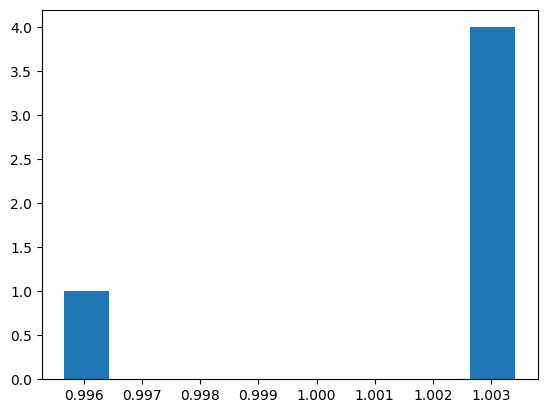

In [96]:
distances = np.linalg.norm(positions-[0,0], axis=1)
dgrid = distances.reshape(position_grid.shape[0:2])

separation_bin = [0.99, 1.01]

sbin = [separation_bin[0],separation_bin[1]]
row_off, col_off = skc.offsets_inbin(positions, position_grid.shape[0:2],sbin)

print(f"Plotting separations for bin {sbin}.")


dists_remain = []
for i in range(len(row_off)):
    dists_remain.append(dgrid[row_off[i], col_off[i]])
plt.hist(dists_remain)
print(len(dists_remain))

In [97]:
jstep = 1
imin = 0
imax = nside//4
jmin = 0
jmax = nside//4

# for each masking scheme, compute Px
Px_randmask, std_randmask, recorded_pairs_randmask = skc.Px_skewers_testmode_semicircle(delta_flux_randmasked_k[:, :, :65], imin, imax, jmin, jmax, jstep, nskew, row_off, col_off)
Px_skyline, std_skyline, recorded_pairs_skyline = skc.Px_skewers_testmode_semicircle(delta_flux_skyline_k[:, :, :65], imin, imax, jmin, jmax, jstep, nskew, row_off, col_off)
Px_dla, std_dla, recorded_pairs_dla = skc.Px_skewers_testmode_semicircle(delta_flux_dla_k[:, :, :65], imin, imax, jmin, jmax, jstep, nskew, row_off, col_off)
Px_fft, std_fft, recorded_pairs_fft = skc.Px_skewers_testmode_semicircle(delta_flux_k_grid[:, :, :65], imin, imax, jmin, jmax, jstep, nskew, row_off, col_off)


For this cpu, there are 368640 pairs to compute.
Ns_side is 768.0
0 percent done
0 percent done
1 percent done
1 percent done
1 percent done
1 percent done
1 percent done
1 percent done
2 percent done
2 percent done
2 percent done
2 percent done
2 percent done
2 percent done
3 percent done
3 percent done
3 percent done
3 percent done
3 percent done
3 percent done
4 percent done
4 percent done
4 percent done
4 percent done
4 percent done
4 percent done
5 percent done
5 percent done
5 percent done
5 percent done
5 percent done
5 percent done
6 percent done
6 percent done
6 percent done
6 percent done
end of Px_array is 0.0385382352947284
For this cpu, there are 368640 pairs to compute.
Ns_side is 768.0
0 percent done
0 percent done
1 percent done
1 percent done
1 percent done
1 percent done
1 percent done
1 percent done
2 percent done
2 percent done
2 percent done
2 percent done
2 percent done
2 percent done
3 percent done
3 percent done
3 percent done
3 percent done
3 percent done
3 per

In [93]:
delta_flux_k.shape

(589824, 68)

(-0.1, 0.1)

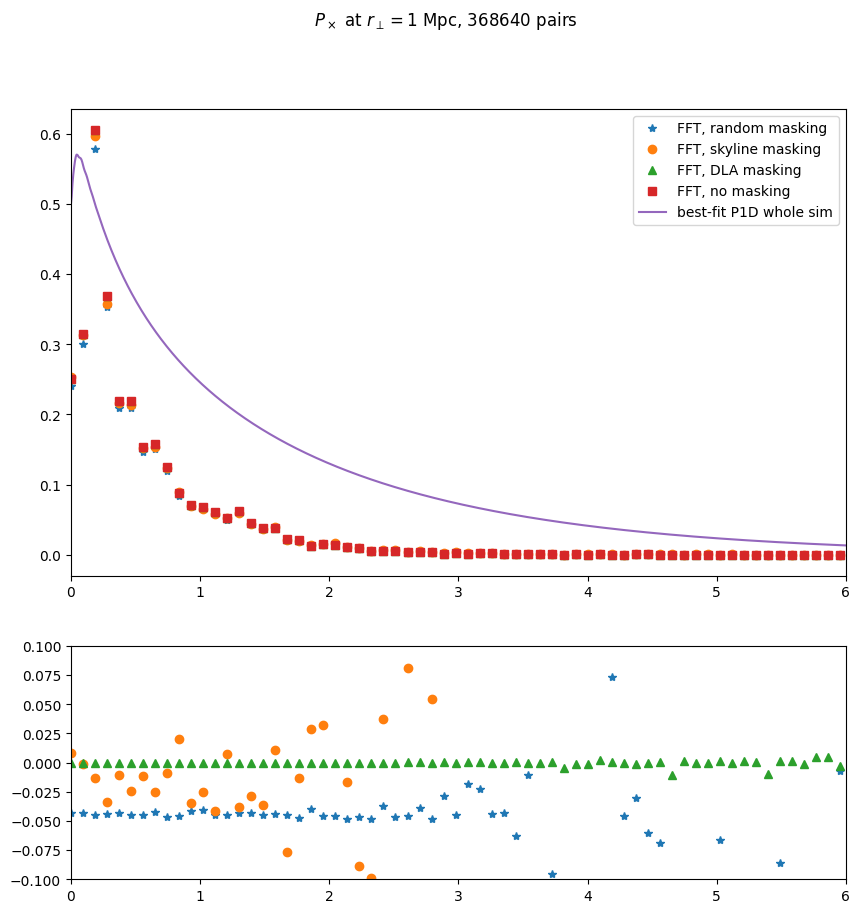

In [103]:

# make a two-panel figure with the lower panel only 1/3 of the size
fig, ax = plt.subplots(2, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(kpar_b[:65], Px_randmask, '*', label='FFT, random masking')
ax[0].plot(kpar_b[:65], Px_skyline, 'o', label='FFT, skyline masking')
ax[0].plot(kpar_b[:65], Px_dla, '^', label='FFT, DLA masking')
ax[0].plot(kpar_b[:65], Px_fft, 's', label='FFT, no masking')
ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim')

# plt.ylim([-1,1])
plt.suptitle(r"$P_\times$ at $r_\perp=1$ Mpc, {:d} pairs".format(len(recorded_pairs_dla)))
ax[0].set_xlim([0,6])
ax[1].set_xlim([0,6])
ax[0].legend()

# plot the pct difference from no-masking in the lower panel
ax[1].plot(kpar_b[:65], (Px_randmask-Px_fft)/Px_fft, '*')
ax[1].plot(kpar_b[:65], (Px_skyline-Px_fft)/Px_fft, 'o')
ax[1].plot(kpar_b[:65], (Px_dla-Px_fft)/Px_fft, '^')
ax[1].set_ylim([-0.1, 0.1])

(-0.1, 0.1)

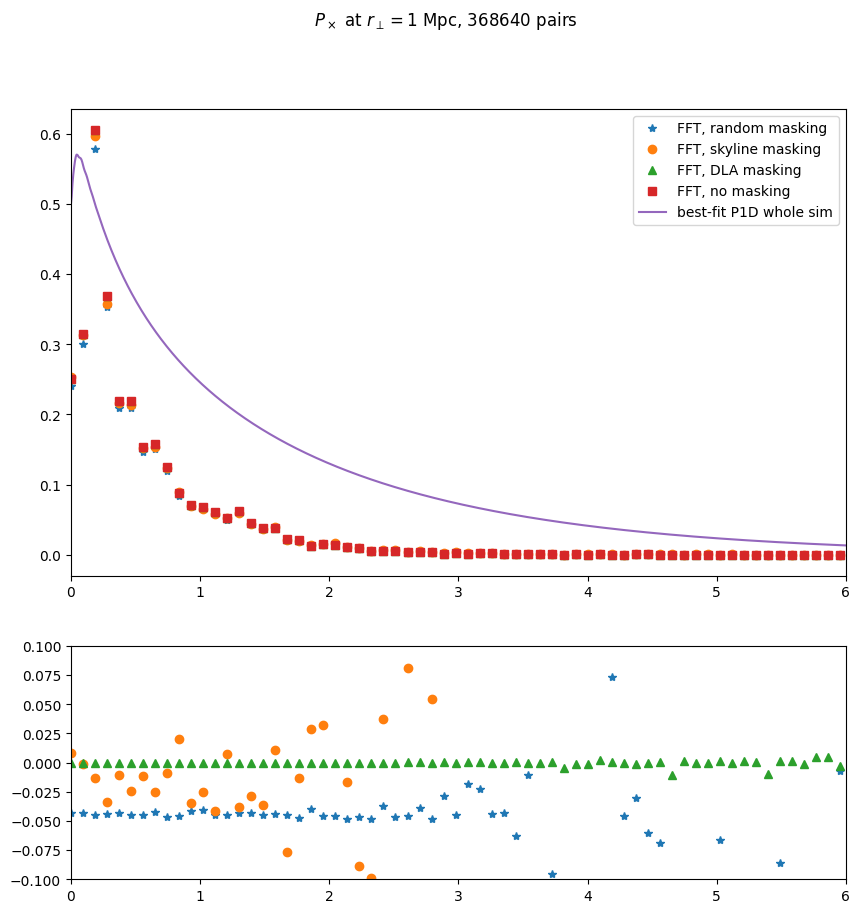

In [ ]:

# make a two-panel figure with the lower panel only 1/3 of the size
fig, ax = plt.subplots(2, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(kpar_b[:65], Px_randmask, '*', label='FFT, random masking')
ax[0].plot(kpar_b[:65], Px_skyline, 'o', label='FFT, skyline masking')
ax[0].plot(kpar_b[:65], Px_dla, '^', label='FFT, DLA masking')
ax[0].plot(kpar_b[:65], Px_dla, 's', label='FFT, no masking')
ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim')

# plt.ylim([-1,1])
plt.suptitle(r"$P_\times$ at $r_\perp=1$ Mpc, {:d} pairs".format(len(recorded_pairs_dla)))
ax[0].set_xlim([0,6])
ax[1].set_xlim([0,6])
ax[0].legend()

# plot the pct difference from no-masking in the lower panel
ax[1].plot(kpar_b[:65], (Px_randmask-Px_fft)/Px_fft, '*')
ax[1].plot(kpar_b[:65], (Px_skyline-Px_fft)/Px_fft, 'o')
ax[1].plot(kpar_b[:65], (Px_dla-Px_fft)/Px_fft, '^')
ax[1].set_ylim([-0.1, 0.1])

In [ ]:
# unmask the delta_flux_b array
type(delta_flux_b)
delta_flux_b_normal = np.asarray(delta_flux_b)
type(delta_flux_b_normal)

numpy.ndarray

In [ ]:
kbin_centers, theta_est, F_alpha_beta, Lalpha, Npairs = est.estimate_px(Np_b, delta_x_matrix_binned, pix_spacing_b, delta_flux_b_normal, row_off, col_off, imax, jmax, jstep, kbin_est[:30], np.zeros(S_fiducial_b.shape), C0_invmat_b, approx_fisher=True)

Starting P1D.
center of kbins:  [0.0, 0.09308422677303092, 0.18616845354606185, 0.2792526803190928, 0.3723369070921237, 0.4654211338651546, 0.5585053606381856, 0.6515895874112164, 0.7446738141842474, 0.8377580409572783, 0.9308422677303092, 1.0239264945033402, 1.1170107212763711, 1.2100949480494019, 1.3031791748224328, 1.3962634015954638, 1.4893476283684948, 1.5824318551415255, 1.6755160819145567, 1.7686003086875874, 1.8616845354606184, 1.9547687622336496, 2.0478529890066803, 2.140937215779711, 2.2340214425527423, 2.327105669325773, 2.4201898960988038, 2.513274122871835, 2.6063583496448657, 2.699442576417897]
Getting derivative matrices.
Starting loop through data.
This k took 9.986703872680664 seconds
This k took 10.925991773605347 seconds
This k took 12.947394132614136 seconds
This k took 16.788940906524658 seconds
This k took 10.38927412033081 seconds
This k took 9.638199090957642 seconds
This k took 10.687772035598755 seconds
This k took 10.618527889251709 seconds
This k took 10.320

In [ ]:
Npairs

15360

Bin the P1D model (initial guess) to match the binning of the $\Delta P_{1D}$ estimates

In [ ]:
Nbin = len(kbin_centers)
p1d_fid = est.bin_model(kfine, p1d_fine, kbin_est, Nbin)


In [ ]:
F_inv = np.linalg.inv(F_alpha_beta)


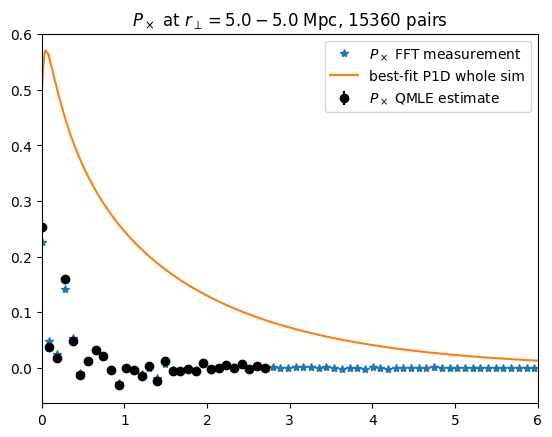

In [ ]:
plt.errorbar(kbin_centers,theta_est, yerr=np.sqrt(np.diag(F_inv)), fmt='o', label=r'$P_\times$ QMLE estimate', color='black')
plt.plot(kpar_b[:65], Px, '*', label=r'$P_\times$ FFT measurement')
plt.plot(kfine, p1d_fine, label='best-fit P1D whole sim')
# plt.ylim([-1,1])
plt.title(r"$P_\times$ at $r_\perp={:.1f}-{:.1f}$ Mpc, {:d} pairs".format(sbin[0], sbin[1], Npairs))
plt.xlim([0,6])
plt.legend()